In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import scipy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import tree
warnings.filterwarnings('ignore')
import graphviz
from IPython.display import Image  
from subprocess import call
from sklearn.metrics import accuracy_score
!pip install pydotplus
import pydotplus
from six import StringIO

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.7/278.7 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for pydotplus: filename=pydotplus-2.0.2-py3-none-any.whl size=24552 sha256=6d36038ca64d94cf45f475e9c94ca6305cb502b95cca63a723b579a7f1ab5d17
  Stored in directory: /root/.cache/pip/wheels/69/b2/67/08f0eef649af92df772c09f451558298e07fab1bc7cdf33db0
Successfully built pydotplus


In [2]:
test_path = '/kaggle/input/2023-tragedi-titanic/test_new.csv'
test = pd.read_csv(test_path)  

In [3]:
train_path = '/kaggle/input/2023-tragedi-titanic/train.csv'
train = pd.read_csv(train_path)

In [4]:
train.head()


,ID,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked,boat,body,home.dest
0,401,3,0,male,NaN,0,0,8.0500,NaN,S,NaN,NaN,NaN
1,402,3,1,female,22.0,1,0,13.9000,NaN,S,16,NaN,"West Haven, CT"
2,403,3,0,male,NaN,0,0,7.3125,NaN,S,NaN,NaN,NaN
3,404,3,0,male,28.0,2,0,7.9250,NaN,S,NaN,NaN,"Ruotsinphytaa, Finland New York, NY"
4,405,3,0,male,NaN,0,0,6.8583,NaN,Q,NaN,NaN,NaN


In [5]:
test.head()

,ID,pclass,sex,age,sibsp,parch,fare,cabin,embarked,boat,body,home.dest
0,1.0,1.0,male,41.0,1.0,0.0,518625.00,D21,S,NaN,NaN,"Southington / Noank, CT"
1,2.0,2.0,female,45.0,0.0,2.0,30.00,NaN,S,12,NaN,London
2,3.0,3.0,male,34.0,0.0,0.0,8.05,NaN,S,NaN,NaN,NaN
3,4.0,1.0,male,56.0,0.0,0.0,35.50,A26,C,3,NaN,"Basel, Switzerland"
4,5.0,1.0,female,55.0,0.0,0.0,277208.00,NaN,C,6,NaN,"Stockholm, Sweden"


In [6]:
train.isnull().sum()


ID             0
pclass         0
survived       0
sex            0
age          192
sibsp          0
parch          0
fare           1
cabin        699
embarked       2
boat         583
body         820
home.dest    393
dtype: int64

In [7]:
test.isnull().sum()

ID             0
pclass         0
sex            0
age           68
sibsp          0
parch          0
fare           0
cabin        300
embarked       0
boat         251
body         368
home.dest    150
dtype: int64

In [8]:
# Fill null in Age Train
x = train['age'].dropna()
hist, bins = np.histogram(x, bins=15)

bin_centers = 0.5 * (bins[:len(bins) - 1] + bins[1:])
probabilities = hist/hist.sum()

# dictionary with random numbers from existing age distribution
train['age_rand'] = train['age'].apply(lambda v: np.random.choice(bin_centers, p=probabilities))
age_null_list = train[train['age'].isnull()].index
train.loc[age_null_list,'age'] = train.loc[age_null_list,'age_rand']

train['age'] = train['age'].round().astype(int)

train.head()

,ID,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked,boat,body,home.dest,age_rand
0,401,3,0,male,40,0,0,8.0500,NaN,S,NaN,NaN,NaN,40.08335
1,402,3,1,female,22,1,0,13.9000,NaN,S,16,NaN,"West Haven, CT",29.43891
2,403,3,0,male,19,0,0,7.3125,NaN,S,NaN,NaN,NaN,18.79447
3,404,3,0,male,28,2,0,7.9250,NaN,S,NaN,NaN,"Ruotsinphytaa, Finland New York, NY",29.43891
4,405,3,0,male,45,0,0,6.8583,NaN,Q,NaN,NaN,NaN,45.40557


In [9]:
test['age'] = pd.to_numeric(test['age'], errors='coerce')
print(test['age'].dtype)


float64


In [10]:
# Check the existing distribution of 'age' column
print(test['age'].describe())

# Fill null in Age Test
x = test['age'].dropna()
hist, bins = np.histogram(x, bins=15)

# Adjust the bin centers calculation
bin_centers = 0.5 * (bins[:-1] + bins[1:])
probabilities = hist / hist.sum()

# Generate random numbers from the existing age distribution
random_values = np.random.choice(bin_centers, size=test['age'].isnull().sum(), p=probabilities)

# Create a Series with random values and NaNs in the appropriate positions
random_series = pd.Series(random_values, index=test.index[test['age'].isnull()])

# Replace null values with random values based on the distribution
test['age_rand'] = test['age'].combine_first(random_series)

# Round and convert 'age' to integer
test['age'] = test['age_rand'].round().astype(int)

# Drop the temporary 'age_rand' column
test.drop('age_rand', axis=1, inplace=True)

# Display the updated DataFrame
test.head()

count    332.000000
mean      29.980422
std       13.594541
min        1.000000
25%       21.000000
50%       28.000000
75%       37.250000
max       74.000000
Name: age, dtype: float64


,ID,pclass,sex,age,sibsp,parch,fare,cabin,embarked,boat,body,home.dest
0,1.0,1.0,male,41,1.0,0.0,518625.00,D21,S,NaN,NaN,"Southington / Noank, CT"
1,2.0,2.0,female,45,0.0,2.0,30.00,NaN,S,12,NaN,London
2,3.0,3.0,male,34,0.0,0.0,8.05,NaN,S,NaN,NaN,NaN
3,4.0,1.0,male,56,0.0,0.0,35.50,A26,C,3,NaN,"Basel, Switzerland"
4,5.0,1.0,female,55,0.0,0.0,277208.00,NaN,C,6,NaN,"Stockholm, Sweden"


In [11]:
#fill null train embarked & fare
mode_embarked = train['embarked'].mode()[0]
mean_fare = train['fare'].mean()

train['embarked'].fillna(value=mode_embarked, inplace=True)
train['fare'].fillna(value=mean_fare, inplace=True)

print(mode_embarked)

S


In [12]:
test.isnull().sum()

ID             0
pclass         0
sex            0
age            0
sibsp          0
parch          0
fare           0
cabin        300
embarked       0
boat         251
body         368
home.dest    150
dtype: int64

In [13]:
train.isnull().sum()

ID             0
pclass         0
survived       0
sex            0
age            0
sibsp          0
parch          0
fare           0
cabin        699
embarked       0
boat         583
body         820
home.dest    393
age_rand       0
dtype: int64

In [14]:
# Gender
genders = {'male': 1, 'female': 0}
train['sex'] = train['sex'].apply(lambda s: genders.get(s))
test['sex'] = test['sex'].apply(lambda s: genders.get(s))

In [15]:
# Embarkment
embarkments = {'U': 0, 'S': 1, 'C': 2, 'Q': 3}
train['embarked'] = train['embarked'].apply(lambda e: embarkments.get(e))
test['embarked'] = test['embarked'].apply(lambda e: embarkments.get(e))

In [16]:
train = train.loc[:,['survived', 'pclass', 'sibsp', 'parch', 'embarked', 'fare', 'age', 'sex']]
train.describe()

,survived,pclass,sibsp,parch,embarked,fare,age,sex
count,909.000000,909.000000,909.000000,909.000000,909.000000,909.000000,909.000000,909.000000
mean,0.376238,2.292629,0.488449,0.353135,1.409241,33.040335,30.187019,0.655666
std,0.484707,0.839656,1.089158,0.780858,0.660198,53.234366,14.641991,0.475412
min,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,0.000000,1.000000,7.895800,21.000000,0.000000
50%,0.000000,3.000000,0.000000,0.000000,1.000000,14.400000,29.000000,1.000000
75%,1.000000,3.000000,1.000000,0.000000,2.000000,31.000000,40.000000,1.000000
max,1.000000,3.000000,8.000000,6.000000,3.000000,512.329200,80.000000,1.000000


In [17]:
train['survived']

0      0
1      1
2      0
3      0
4      0
      ..
904    0
905    0
906    1
907    0
908    0
Name: survived, Length: 909, dtype: int64

In [18]:
print("Train 'fare' column dtype:", train['fare'].dtype)
print("Test 'fare' column dtype:", test['fare'].dtype)


# Clean the 'fare' column in both train and test DataFrames
#train['fare'] = train['fare'].str.replace(',', '.').astype(float)
#test['fare'] = test['fare'].str.replace(',', '.').astype(float)
# Clean the 'fare' column by removing non-numeric characters
train['fare'] = train['fare'].replace('[^\d.]', '', regex=True).astype(float)
test['fare'] = test['fare'].replace('[^\d.]', '', regex=True).astype(float)


# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Columns to be scaled
columns = ['pclass', 'sibsp', 'parch', 'embarked', 'fare', 'age', 'sex']

# Normalization on the training data
train_scaled = pd.DataFrame(scaler.fit_transform(train[columns]), columns=columns)
train_scaled['survived'] = train['survived']

# Normalization on the test data using the same scaler as used on the training data
test_scaled = pd.DataFrame(scaler.transform(test[columns]), columns=columns)


Train 'fare' column dtype: float64
Test 'fare' column dtype: float64


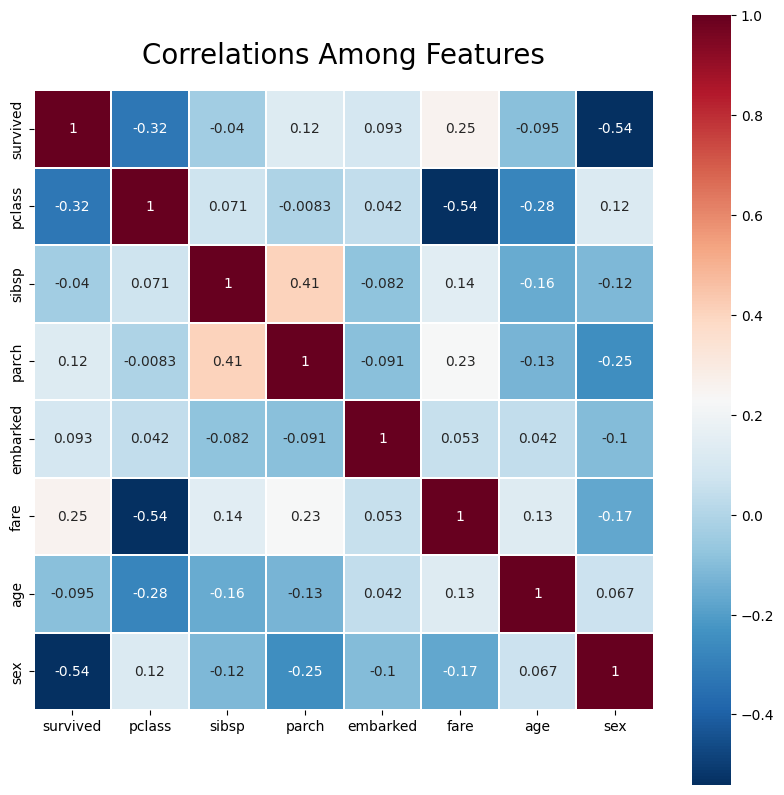

In [19]:
plt.subplots(figsize = (10,10))
data = train.loc[:,['survived','pclass', 'sibsp', 'parch', 'embarked', 'fare', 'age', 'sex']]
sns.heatmap(data.corr(),
            annot=True,
            cmap = 'RdBu_r',
            linewidths=0.1, 
            linecolor='white',
            square=True)
plt.title("Correlations Among Features", y = 1.03,fontsize = 20)
plt.show()

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
X_train = train_scaled.drop('survived', axis=1)
y_train = train_scaled['survived']
# Bangun model Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# Prediksi pada set pengujian
X_test = train_scaled.drop('survived', axis=1)
y_test = train_scaled['survived']
dt_predictions = dt_model.predict(X_test)

# Evaluasi model Decision Tree
dt_accuracy = accuracy_score(y_test, dt_predictions)
dt_confusion_mat = confusion_matrix(y_test, dt_predictions)
dt_classification_rep = classification_report(y_test, dt_predictions)

# Tampilkan hasil evaluasi
print("Decision Tree Model Evaluation:")
print(f'Accuracy: {dt_accuracy}')
print(f'Confusion Matrix:\n{dt_confusion_mat}')
print(f'Classification Report:\n{dt_classification_rep}')

# Prediksi pada data uji menggunakan Decision Tree
dt_test_predictions = dt_model.predict(test_scaled)

# Buat DataFrame untuk menyimpan hasil prediksi Decision Tree
dt_result_df = pd.DataFrame({
    'ID': test['ID'],
    'Predicted': dt_test_predictions
})

# Export DataFrame ke file CSV
dt_result_df.to_csv('predicted_results_dt.csv', index=False)


Decision Tree Model Evaluation:
Accuracy: 0.976897689768977
Confusion Matrix:
[[566   1]
 [ 20 322]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       567
           1       1.00      0.94      0.97       342

    accuracy                           0.98       909
   macro avg       0.98      0.97      0.98       909
weighted avg       0.98      0.98      0.98       909



In [21]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Pisahkan fitur dan label pada data pelatihan yang sudah dinormalisasi
features = train_scaled.drop('survived', axis=1)
labels = train_scaled['survived']

# Pisahkan data pelatihan menjadi set pelatihan dan pengujian
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Bangun model Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Prediksi pada set pengujian
rf_predictions = rf_model.predict(X_test)

# Evaluasi model Random Forest
rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_confusion_mat = confusion_matrix(y_test, rf_predictions)
rf_classification_rep = classification_report(y_test, rf_predictions)

# Tampilkan hasil evaluasi
print("Random Forest Model Evaluation:")
print(f'Accuracy: {rf_accuracy}')
print(f'Confusion Matrix:\n{rf_confusion_mat}')
print(f'Classification Report:\n{rf_classification_rep}')

# Prediksi pada data uji menggunakan Random Forest
rf_test_predictions = rf_model.predict(test_scaled)

# Buat DataFrame untuk menyimpan hasil prediksi Random Forest
rf_result_df = pd.DataFrame({
    'ID': test['ID'],
    'Predicted': rf_test_predictions
})

# Export DataFrame ke file CSV
rf_result_df.to_csv('predicted_results_rf.csv', index=False)


Random Forest Model Evaluation:
Accuracy: 0.8131868131868132
Confusion Matrix:
[[104  13]
 [ 21  44]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       117
           1       0.77      0.68      0.72        65

    accuracy                           0.81       182
   macro avg       0.80      0.78      0.79       182
weighted avg       0.81      0.81      0.81       182



In [22]:
from sklearn.svm import SVC
features = train_scaled.drop('survived', axis=1)
labels = train_scaled['survived']
# Pisahkan data pelatihan menjadi set pelatihan dan pengujian
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Bangun model Support Vector Machine (SVM)
svm_model = SVC(random_state=42)
svm_model.fit(X_train, y_train)

# Prediksi pada set pengujian
svm_predictions = svm_model.predict(X_test)

# Evaluasi model SVM
svm_accuracy = accuracy_score(y_test, svm_predictions)
svm_confusion_mat = confusion_matrix(y_test, svm_predictions)
svm_classification_rep = classification_report(y_test, svm_predictions)

# Tampilkan hasil evaluasi
print("SVM Model Evaluation:")
print(f'Accuracy: {svm_accuracy}')
print(f'Confusion Matrix:\n{svm_confusion_mat}')
print(f'Classification Report:\n{svm_classification_rep}')

# Prediksi pada data uji menggunakan SVM
svm_test_predictions = svm_model.predict(test_scaled)

# Buat DataFrame untuk menyimpan hasil prediksi SVM
svm_result_df = pd.DataFrame({
    'ID': test['ID'],
    'survived': svm_test_predictions
})

# Export DataFrame ke file CSV
svm_result_df.to_csv('predicted_results_svm.csv', index=False)

SVM Model Evaluation:
Accuracy: 0.8406593406593407
Confusion Matrix:
[[113   4]
 [ 25  40]]
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.97      0.89       117
           1       0.91      0.62      0.73        65

    accuracy                           0.84       182
   macro avg       0.86      0.79      0.81       182
weighted avg       0.85      0.84      0.83       182



In [23]:
from sklearn.neighbors import KNeighborsClassifier

# Pisahkan data pelatihan menjadi set pelatihan dan pengujian
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Bangun model K-Nearest Neighbors (KNN)
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)

# Prediksi pada set pengujian
knn_predictions = knn_model.predict(X_test)

# Evaluasi model KNN
knn_accuracy = accuracy_score(y_test, knn_predictions)
knn_confusion_mat = confusion_matrix(y_test, knn_predictions)
knn_classification_rep = classification_report(y_test, knn_predictions)

# Tampilkan hasil evaluasi
print("KNN Model Evaluation:")
print(f'Accuracy: {knn_accuracy}')
print(f'Confusion Matrix:\n{knn_confusion_mat}')
print(f'Classification Report:\n{knn_classification_rep}')

# Prediksi pada data uji menggunakan KNN
knn_test_predictions = knn_model.predict(test_scaled)

# Buat DataFrame untuk menyimpan hasil prediksi KNN
knn_result_df = pd.DataFrame({
    'ID': test['ID'],
    'survived': knn_test_predictions
})

# Export DataFrame ke file CSV
knn_result_df.to_csv('predicted_results_knn.csv', index=False)


KNN Model Evaluation:
Accuracy: 0.8186813186813187
Confusion Matrix:
[[104  13]
 [ 20  45]]
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.89      0.86       117
           1       0.78      0.69      0.73        65

    accuracy                           0.82       182
   macro avg       0.81      0.79      0.80       182
weighted avg       0.82      0.82      0.82       182

